In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import sklearn
import re
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from datetime import date
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from nltk.tokenize import word_tokenize
import scipy as sp
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc,\
                            roc_auc_score
from keras import backend as K
from keras.models import load_model
import tensorflow as keras
from tensorflow import keras
from keras import layers
import warnings
warnings.filterwarnings('ignore')

In [2]:
books = pd.read_csv('./books.csv', index_col=1)
books = books.iloc[:, 1:]
ratings = pd.read_csv('./ratings.csv')
book_tags = pd.read_csv('./book_tags.csv')
tags = pd.read_csv('./tags.csv')
to_read = pd.read_csv('to_read.csv')

In [4]:
Xtrain, Xtest = train_test_split(ratings, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (4781183, 3)
Shape of test data: (1195296, 3)


In [9]:
users_id, books_id, _ = ratings.nunique()

In [ ]:
keras.layer

In [41]:
input_books = keras.layers.Input(shape=[1])
embed_books = keras.layers.Embedding(books_id + 1,15)(input_books)
books_out = keras.layers.Flatten()(embed_books)

#user input network
input_users = keras.layers.Input(shape=[1])
embed_users = keras.layers.Embedding(users_id + 1,15)(input_users)
users_out = keras.layers.Flatten()(embed_users)

conc_layer = keras.layers.Concatenate()([books_out, users_out])
x = keras.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = keras.layers.Dense(1, activation='relu')(x)
model = keras.Model([input_books, input_users], x_out)

In [51]:
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')

In [52]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 15)        150015      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 15)        801375      input_5[0][0]                    
____________________________________________________________________________________________

In [53]:
hist = model.fit([Xtrain.book_id, Xtrain.user_id], Xtrain.rating, 
                 batch_size=64, 
                 epochs=5, 
                 verbose=1,
                 validation_data=([Xtest.book_id, Xtest.user_id], Xtest.rating))

Epoch 1/5
74706/74706 [==============================] - 571s 8ms/step - loss: 0.7809 - val_loss: 0.7391
Epoch 2/5
74706/74706 [==============================] - 569s 8ms/step - loss: 0.7087 - val_loss: 0.7026
Epoch 3/5
74706/74706 [==============================] - 545s 7ms/step - loss: 0.6746 - val_loss: 0.6890
Epoch 4/5
74706/74706 [==============================] - 637s 9ms/step - loss: 0.6510 - val_loss: 0.6818
Epoch 5/5
74706/74706 [==============================] - 589s 8ms/step - loss: 0.6321 - val_loss: 0.6804


In [54]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
hist.history

{'loss': [0.7808553576469421,
  0.7087376713752747,
  0.674611508846283,
  0.6509748101234436,
  0.6321432590484619],
 'val_loss': [0.7390897274017334,
  0.7025852203369141,
  0.6890448331832886,
  0.6818010807037354,
  0.6804294586181641]}

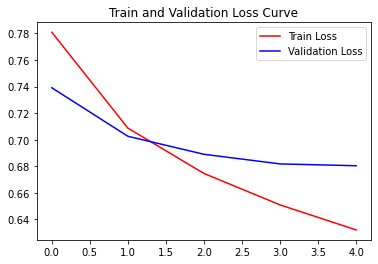

In [56]:
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [78]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


In [58]:
# Extract embeddings
book_em = model.get_layer('embedding_2')
book_em_weights = book_em.get_weights()[0]
book_em_weights.shape

(10001, 15)

- predict

In [69]:
book_arr = np.array(b_id) #get all book IDs
user = np.array([100 for i in range(len(b_id))])
pred = model.predict([book_arr, user])
pred

array([[3.5329437],
       [3.3704877],
       [3.4019933],
       ...,
       [3.1214485],
       [3.1810422],
       [2.8816795]], dtype=float32)

JSON format

In [72]:
web_book_data = books.reset_index()[["book_id", "title", "image_url", "authors"]]
web_book_data = web_book_data.sort_values('book_id')
web_book_data.to_json(r'web_book_data.json', orient='records')

In [87]:
! saved_model_cli show --dir 0/ --all

2021-08-30 19:05:57.871748: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-08-30 19:05:57.871780: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Traceback (most recent call last):
  File "c:\users\sakura\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\sakura\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Sakura\anaconda3\Scripts\saved_model_cli.exe\__main__.py", line 7, in <module>
  File "c:\users\sakura\anaconda3\lib\site-packages\tensorflow\python\tools\saved_model_cli.py", line 1192, in main
    args.func(args)
  File "c:\users\sakura\anaconda3\lib\site-packages\tensorflow\python\tools\saved_model_cli.py", line 719, in show
    _show_all(args.dir)
  File "c:\users\sakura\anaco